$$
\phi_r[n] = \phi[n] - \phi[n-H] - \frac{2\pi k H}{N} 
$$

$$
\begin{aligned}
\omega[n] - \omega_k &= \frac{\text{wrap}(\phi_r[n])}{H} \\
\omega[n] &= \frac{\text{wrap}(\phi_r[n])}{H} + \omega_k
\end{aligned}
$$

$$
\begin{aligned}
b[n] - k &= \frac{\text{wrap}(\phi_r[n])N}{2 \pi H} \\
b[n] &= \frac{\text{wrap}(\phi_r[n])N}{2 \pi H} + k
\end{aligned}
$$

Synthesis Step:

$R$ denotes ratio

1.Mutiply each frequency component by the pitch shift value:

$$
b_s[n] = Rb_a[n]
$$

2.Check which bin the componentt belongs in:

$$
k' = \text{floor}(Rk+0.5)
$$

3.Calculate the phase of the new bins:

$$
\phi_{rs}[n] = \frac{2 \pi H (b_s[n] - k')}{N}
$$

4.Convert the magnitude and phase to real and imaginary components:

$$
\phi_s[n] = \text{wrap}(\phi_s[n-H] + \phi_{rs}[n] + \frac{2 \pi k' H}{N})
$$

In [1]:
import math 
import numpy as np
from scipy import signal 
import matplotlib.pyplot as plt
import wavio
import IPython
import random

In [2]:
def P2R(A, phi):
    return A * ( np.cos(phi) + np.sin(phi) * 1j )

In [3]:
def PreProcessData(xn, frameSize, stepSize):
    padding = len(xn) % stepSize
    if(padding == 0):
        temp = xn
    else:
        temp = np.append(xn, np.zeros(stepSize - padding))
    
    iteration = int(len(temp) // stepSize) - int(frameSize // stepSize) + 1
    dataSet = np.zeros([iteration, frameSize])
    
    for i in range(iteration):
        start = i * stepSize
        end = start + frameSize
        dataSet[i] = temp[start:end]
        
    return dataSet, temp, len(temp), iteration

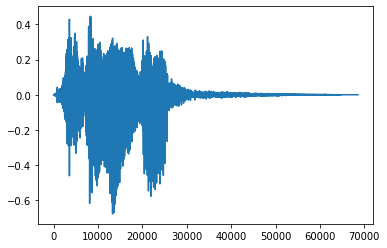

In [4]:
file = wavio.read("china.wav")
fixed_data0 = file.data[:, 0]
fixed_data1 = file.data[:, 1]
data = fixed_data0.astype(np.float32, order='C') / 32767.0

plt.plot(data)
plt.show()

IPython.display.display(IPython.display.Audio("china.wav", rate=file.rate))

In [5]:
fs = file.rate
frameSize = 1024
stepSize = 128
dataSet, data, length, iteration = PreProcessData(data, frameSize, stepSize)

In [6]:
def wrapPhase(input_data):
    if (input_data >= 0):
        return math.fmod(input_data + np.pi, 2.0 * np.pi) - np.pi
    else:
        return math.fmod(input_data - np.pi, -2.0 * np.pi) + np.pi
    
output = np.zeros(length)

lastInputPhases = np.zeros(frameSize)
lastOutputPhases = np.zeros(frameSize)

analysisMagnitudes = np.zeros(frameSize//2 + 1)
analysisFrequencies = np.zeros(frameSize//2 + 1)

synthesisMagnitudes = np.zeros(frameSize//2 + 1)
synthesisFrequencies = np.zeros(frameSize//2 + 1)

X_synthesis = np.zeros(frameSize, dtype=complex)

SemiTones = -5
PitchShift = np.power(2.0, SemiTones / 12.0)

for i in range(iteration):
    temp = dataSet[i] * signal.hann(frameSize)
    temp = dataSet[i]
    
    # Apply FFT
    X = np.fft.fft(temp)

    amplitude_vec = np.abs(X)
    phase_vec = np.angle(X)
    
    for n in range(frameSize//2):
        amplitude = amplitude_vec[n]
        phase = phase_vec[n] 
        
        # Calculate the phase difference in this bin between the last
        # hop and this one, which will indirectly give us the exact frequency
        phaseDiff = phase - lastInputPhases[n]
        
        
        # Subtract the amount of phase increment we'd expect to see based
        # on the centre frequency of this bin (2*pi*n/gFftSize) for this
        # hop size, then wrap to the range -pi to pi
        binCentreFrequency = 2 * np.pi * n / frameSize
        phaseDiff = wrapPhase(phaseDiff - binCentreFrequency * stepSize)
        
        # Find deviation in (fractional) number of bins from the centre frequency
        binDeviation = phaseDiff * frameSize / stepSize / (2 * np.pi)
        
        # Add the original bin number to get the fractional bin where this partial belongs
        analysisFrequencies[n] = n + binDeviation
        
        #  Save the magnitude for later and for the GUI
        analysisMagnitudes[n] = amplitude
        
        # Save the phase for next hop
        lastInputPhases[n] = phase
    
    # Zero out the synthesis bins, ready for new data
    for n in range(frameSize//2):
        synthesisMagnitudes[n] = 0
        synthesisFrequencies[n] = 0
    
    # Handle the pitch shift, storing frequencies into new bins
    for n in range(frameSize//2):
        newBin = math.floor(n * PitchShift + 0.5)
        
        # gnore any bins that have shifted above Nyquist
        if(newBin <= frameSize//2):
            synthesisMagnitudes[newBin] += analysisMagnitudes[n]
            synthesisFrequencies[newBin] = analysisFrequencies[n] * PitchShift
    
    # Synthesise frequencies into new magnitude and phase values for FFT bins
    for n in range(frameSize//2):
        amplitude = synthesisMagnitudes[n]
        
        binDeviation = synthesisFrequencies[n] - n
        
        phaseDiff = binDeviation * 2 * np.pi * stepSize / frameSize
        
        binCentreFrequency = 2 * np.pi * n / frameSize
        phaseDiff += binCentreFrequency * stepSize
        
        outPhase = wrapPhase(lastOutputPhases[n] + phaseDiff)
        
        # Final output
        X_synthesis[n] = amplitude * np.cos(outPhase) + amplitude * np.sin(outPhase) * 1j
        
        # Mirror the other half data
        if(n > 0 and n < frameSize//2): X_synthesis[frameSize - n] = X_synthesis[n]
        
        lastOutputPhases[n] = outPhase
    
    # Apply Inverse FFT
    yn = np.fft.ifft(X_synthesis).real * signal.hann(frameSize)
    
    start = i * stepSize
    end = start + frameSize
    
    output[start:end] = output[start:end] + yn

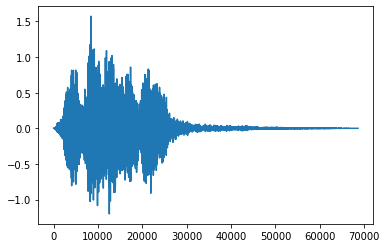

In [7]:
plt.plot(output)
plt.show()
wavio.write("output.wav", output, fs, sampwidth=3)
IPython.display.display(IPython.display.Audio("output.wav", rate=fs))